<a href="https://colab.research.google.com/github/YuruHuang/deep-learning-menu-healthiness/blob/main/03_FastAI_Experiments_Categorical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I aim to replicate what Tom Bishop has done with takeaway cuisine classifier using restaurant names. His code is available on github: https://github.com/tombisho/takeaways. The menu healthiness scores are divided into tertiles: "high", "medium", and "low".  

# Data Preparation 

* convert special characters to ascii encoding
* remove duplicates (no removal of chains for this project)
* train test split




In [1]:
# read in the data (just the name and healthiness scores)
import pandas as pd
from sklearn.metrics import mean_absolute_error


from sklearn.model_selection import train_test_split
justeat_menu = pd.read_csv('JustEat_extracted_211021.csv')
justeat_menu.head()

,Restaurant ID,Desserts,Vegetables,Salads,Chips,Water,Milk,Special Offers,rest_name,n_reviews,average_review,item_price_mean,item_price_median,n_items,url,cuisine,address,postcode,postcode_district,specialOffers,chips,salads,predict,rating2,review
0,80603,0,5,2,11,1,0,5,Pasha Kebabs & Pizzas,View 551 reviews,5.06 stars out of 6.,6.037634,7.000,93,URL,"Kebab,Pizza,Halal","25 Windmill Brae, Aberdeen, AB11 6HU",AB11 6HU,AB11,5,11,2,5.504342,1,551.0
1,71703,7,10,2,14,0,0,4,Paco's Tacos,View 2314 reviews,4.65 stars out of 6.,5.431358,4.450,162,URL,"Mexican,American","42-44 Market Street, Aberdeenshire, AB11 5PL",AB11 5PL,AB11,4,14,2,5.010865,0,2314.0
2,6885,0,16,12,1,0,0,2,Dil Se,View 1392 reviews,5.19 stars out of 6.,7.473418,8.225,158,URL,"Indian,Curry","Unit 8, The Green Berrymuir Road, Portlethen, ...",AB12 4UN,AB12,2,1,12,9.355489,4,1392.0
3,122605,5,10,6,44,0,0,1,Mannofield Pizza Grill and Kebab,View 386 reviews,5.16 stars out of 6.,8.069737,7.700,152,URL,"Pizza,Kebab","483a Great Western Road, Aberdeen, AB10 6NN",AB10 6NN,AB10,1,15,6,5.642945,1,386.0
4,44832,0,16,2,1,0,0,2,Lasan Healthy Indian Brasserie,View 595 reviews,5.04 stars out of 6.,6.877143,4.500,105,URL,"Indian,Healthy","Unit 2 Westhill Drive, Westhill, Aberdeenshire...",AB32 6FS,AB32,2,1,2,8.357649,3,595.0


In [2]:
# remove white space and convert the strings to lower cases
justeat_menu['rest_name_clean'] = justeat_menu.rest_name.str.lower()
justeat_menu['rest_name_clean'] = justeat_menu.rest_name_clean.str.strip()

In [3]:
from collections import Counter
import string
# what special characters in our dataset? 
foreign_chars = Counter(_ for _ in ''.join(str(list(justeat_menu.rest_name_clean))) if _ not in string.ascii_letters)
foreign_chars.most_common(10)

[(' ', 165143),
 ("'", 103619),
 (',', 55704),
 ('"', 11386),
 ('-', 11022),
 ('&', 4116),
 ('®', 1786),
 ('(', 1045),
 (')', 1043),
 ('1', 776)]

In [4]:
!pip install unidecode
from unidecode import unidecode

justeat_menu['ascii_name'] = justeat_menu.rest_name_clean.apply(lambda x: unidecode(str(x)))
justeat_menu[justeat_menu.rest_name_clean != justeat_menu.ascii_name][['rest_name_clean','ascii_name']].head()

     |████████████████████████████████| 235 kB 4.2 MB/s 


,rest_name_clean,ascii_name
12,mcdonald's® - asda aberdeen,mcdonald's(r) - asda aberdeen
21,mcdonald's® - aberdeen city centre,mcdonald's(r) - aberdeen city centre
58,mcdonald's® - aberdeen kittybrewster,mcdonald's(r) - aberdeen kittybrewster
101,sugar & crème,sugar & creme
107,tasty delight café and desserts,tasty delight cafe and desserts


In [6]:
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name.str.replace('`',"'")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('~'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace(']'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('['," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('\\'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('%'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('*'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace(':'," ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('+'," and ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('&'," and ")
justeat_menu['ascii_name_fix'] = justeat_menu.ascii_name_fix.str.replace('/'," ")

In [7]:
# remove duplicates - average values
name_classes = justeat_menu.groupby('ascii_name').size().reset_index(name='counts')
name_classes[name_classes.counts > 10].head(10)

,ascii_name,counts
958,ali baba,11
1688,aroma,11
3029,bella pizza,21
3146,bengal spice,27
3256,best kebab,23
4132,bombay spice,12
6738,charcoal grill,41
7047,chicago pizza,12
7293,chicken express,13
7313,chicken hut,19


In [8]:
# for the ones with the same name, get the average of the ratings 
justeat_df = justeat_menu[['ascii_name','predict']].groupby('ascii_name').mean().reset_index()
justeat_df.tail()


,ascii_name,predict
46606,zweton,6.481052
46607,zyara restaurant,9.199473
46608,zyka,7.669501
46609,zykaa indian cuisine,8.244248
46610,zzang,8.122103


In [9]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(justeat_df.ascii_name, justeat_df.predict, test_size=0.1, random_state=42)

In [10]:
# create healthiness tertiles (convert the regression problem to a classification problem)
y_train.quantile(q=[0,1/3,2/3,1]), y_test.quantile(q=[0,1/3,2/3,1])

(0.000000    -6.722594
 0.333333     5.847206
 0.666667     6.945181
 1.000000    11.174057
 Name: predict, dtype: float64, 0.000000    -3.709883
 0.333333     5.899660
 0.666667     6.994622
 1.000000    10.437079
 Name: predict, dtype: float64)

In [11]:
def score_to_rating_tert(val):
  return (pd.cut(val,
                 bins=[-10000, 5.847206,6.945181,10000],
                 labels=['Lowest Tertile','Medium Tertile','Highest Tertile']))

In [12]:
y_train_cat = score_to_rating_tert(y_train)
y_test_cat = score_to_rating_tert(y_test)

In [27]:
# what is the mean absolute error if I assume uniformed distribution of the mean 
from statistics import mean
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, [mean(y_train)]*len(y_test)))

1.0824678067377858


# Encoder

In [17]:
#! pip install fastai
from fastai import *
from fastai.text import *

In [18]:
class LetterTokenizer(BaseTokenizer):
    "Character level tokenizer function."
    def __init__(self, lang): pass
    def tokenizer(self, t:str) -> List[str]:
        out = []
        i = 0
        while i < len(t):
            if t[i:].startswith(BOS):
                out.append(BOS)
                i += len(BOS)
            else:
                out.append(t[i])
                i += 1
        return out
            
    def add_special_cases(self, toks:Collection[str]): pass

In [19]:
itos = [UNK, BOS] + list(string.ascii_lowercase + " -'@&)(." +"0123456789")

In [20]:
vocab=Vocab(itos)
tokenizer=Tokenizer(LetterTokenizer, pre_rules=[], post_rules=[])

In [21]:
train_df = pd.DataFrame({'label_final':y_train_cat, 'rest_name':X_train})
test_df = pd.DataFrame({'label_final':y_test_cat, 'rest_name':X_test})

In [28]:
train_df.head(20)

,label_final,rest_name
22451,Highest Tertile,love jerk
2342,Highest Tertile,bahgecha
40834,Highest Tertile,the conservatory tea room
35143,Medium Tertile,shpoon
1786,Medium Tertile,asda kitchen - gosforth
11090,Lowest Tertile,doorstep desserts - st matthews
25941,Highest Tertile,muffin break - eastbourne
11225,Highest Tertile,dragon boat new bradwell
28721,Lowest Tertile,papa'z pizza
19570,Lowest Tertile,kebabies


In [25]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
data = TextLMDataBunch.from_df(path='.', train_df=train_df, valid_df=test_df,
                         tokenizer=tokenizer, vocab=vocab, text_cols=1, mark_fields=False, bs=128)

In [47]:
learn = language_model_learner(data, AWD_LSTM,drop_mult=1)

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


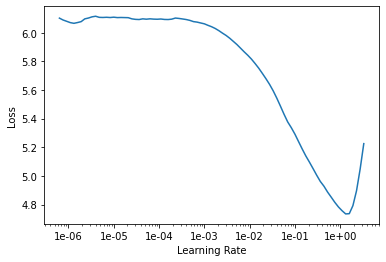

In [ ]:
learn.recorder.plot()

In [48]:
learn.freeze()

In [49]:
lr = 1e-2
moms = (0.8,0.7) # what does this mean? 
cycles = 25

In [50]:
learn.fit_one_cycle(cycles, lr, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,5.094089,4.339580,0.079028,00:47
1,3.889882,2.991859,0.153105,00:47
2,3.081640,2.591023,0.246317,00:46
3,2.706225,2.371969,0.296571,00:46
4,2.505290,2.232688,0.339468,00:46
5,2.397385,2.148906,0.368760,00:46
6,2.326600,2.087746,0.386577,00:46
7,2.301157,2.051445,0.397230,00:46
8,2.282994,2.023506,0.401816,00:46
9,2.265049,2.013077,0.402547,00:46


In [51]:
learn.freeze_to(-2)
learn.fit_one_cycle(cycles, slice((lr/2)/(2.6**4),lr/2), moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,2.164247,1.910815,0.433239,00:49
1,2.106410,1.861076,0.445028,00:49
2,2.023981,1.791608,0.468141,00:49
3,1.926123,1.704839,0.491345,00:49
4,1.837786,1.620204,0.516112,00:49
5,1.746903,1.562529,0.530164,00:49
6,1.649003,1.474305,0.558776,00:49
7,1.596938,1.430102,0.569227,00:49
8,1.533636,1.388846,0.584903,00:49
9,1.502511,1.356620,0.592462,00:49


In [52]:
learn.freeze_to(-3)
learn.fit_one_cycle(cycles, slice((lr/4)/(2.6**4),lr/4), moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,1.313120,1.225780,0.631788,00:58
1,1.310253,1.225001,0.632052,00:58
2,1.321842,1.223101,0.632640,00:58
3,1.298110,1.216953,0.633989,00:58
4,1.295695,1.212383,0.635856,00:58
5,1.276447,1.204751,0.637632,00:58
6,1.278138,1.197189,0.639397,00:58
7,1.266584,1.189782,0.640513,00:58
8,1.259013,1.183848,0.641782,00:58
9,1.248679,1.176967,0.644470,00:58


In [53]:
learn.unfreeze()
learn.fit_one_cycle(cycles, slice((lr/8)/(2.6**4),lr/8), moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,1.173548,1.139681,0.655235,01:04
1,1.171042,1.138742,0.655418,01:04
2,1.177325,1.139541,0.655824,01:04
3,1.178182,1.138315,0.655854,01:04
4,1.169506,1.136324,0.656463,01:04
5,1.174302,1.135643,0.656220,01:04
6,1.171739,1.132420,0.656788,01:04
7,1.163434,1.129768,0.657944,01:04
8,1.168820,1.127530,0.659101,01:04
9,1.156879,1.125472,0.658695,01:04


In [54]:
TEXT = "bob"
N_WORDS = 1000
N_SENTENCES = 1

In [55]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

bob b y ' s   b u r g e r   c a f e xxbos   c a f e   s t a r   c o f f e e   &   s h a k e s xxbos   l a   r i c h   a n d   k a i d a xxbos   g e n i t a   b i t e s xxbos   c h i c k e n   c o t t a g e   -   c h e l t e n h a m   r o a d xxbos   t h e   r o l l y ' s   f i s h   &   c h i p s xxbos   i c e   c h i n e s e   t a k e a w a y xxbos   p e p e ' s   p i r i   p i r i   -   s o u t h   n e w   q u a y xxbos   b u r g e r   k i n g   -   n o r w i c h   -   b e x l e y h e a t h xxbos   e t h e m u g h a l ' s   c a f e xxbos   m c d o n a l d ' s ( r )   -   l e i c e s t e r   -   w a l w o r t h xxbos   e v e r e s t   s a n d w i c h e s xxbos   s t a c k s   -   m a n c h e s t e r   a l b e n t a l xxbos   t h e   f r y e r xxbos   i t a l i a n   t a k e a w a y xxbos   m a n z i l xxbos   o l i v e   t a n d o o r i xxbos   s t a r b u c k s ( r )   -   b o a r n e   -   i n t e r n a t o l e y   s q u a r e xxbos   m o r l e y ' s ( r )   -   b l a c k p o o l   

In [58]:
learn.save_encoder('just_eat_enc_bs128_2_31-12-21')

# Classification Models

In [61]:
data = TextClasDataBunch.from_df(path='.', train_df=train_df, valid_df=test_df,
                         tokenizer=tokenizer, vocab=vocab,
                         mark_fields=False, bs=128)

In [62]:
learn_class = text_classifier_learner(data, AWD_LSTM,drop_mult=1.0)

In [63]:
learn_class.load_encoder('just_eat_enc_bs128_2_31-12-21')
learn_class.unfreeze()

In [64]:
lr = 1e-3
moms = (0.7,0.8)
cycles = 25

learn.fit_one_cycle(cycles, lr, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,1.125138,1.110956,0.663099,01:05
1,1.132341,1.111082,0.663129,01:05
2,1.128743,1.109902,0.663190,01:04
3,1.117620,1.106611,0.664123,01:04
4,1.128747,1.104412,0.664692,01:04
5,1.116060,1.104252,0.664012,01:04
6,1.109451,1.096454,0.667421,01:04
7,1.102927,1.093328,0.669146,01:04
8,1.086587,1.086238,0.671165,01:04
9,1.082575,1.081821,0.672768,01:04


In [66]:
learn.fit_one_cycle(cycles, lr, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.947693,1.067488,0.680814,01:04
1,0.941523,1.068026,0.680560,01:04
2,0.944509,1.068063,0.680530,01:04
3,0.967513,1.070483,0.679657,01:04
4,0.959014,1.069523,0.680256,01:04
5,0.960923,1.072912,0.680286,01:04
6,0.962471,1.072356,0.679282,01:04
7,0.952665,1.075307,0.679485,01:04
8,0.945911,1.072611,0.680895,01:04
9,0.944144,1.075917,0.680256,01:04


In [65]:
learn.save('31_12_2021_fastai')